ENERGY ARBITRAGE VALUE ANALYSIS including price forecasts with XGB model instead of perfect foresight prices for year 2018.

In [1]:
##############################
## IMPORT AND PREPARE DATA ##
############################
import numpy as np
import pandas as pd
from datetime import datetime
from typing import List
from pyomo.environ import *

# Import data
filename1 = 'HOEP_2015-2019_dataset.csv'
XGboost_2018 = pd.read_csv('HOEP_2018_forecast_XGB1.csv')
XGboost6_2018 = pd.read_csv('HOEP_2018_forecast_XGB6.csv')
XGboost12_2018 = pd.read_csv('HOEP_2018_forecast_XGB12.csv')
XGboost13_2018 = pd.read_csv('HOEP_2018_forecast_XGB13.csv')
XGboost16_2018 = pd.read_csv('HOEP_2018_forecast_XGB16.csv')
XGboost23_2018 = pd.read_csv('HOEP_2018_forecast_XGB23.csv')
XGboost24_2018 = pd.read_csv('HOEP_2018_forecast_XGB24.csv')

dataframe = pd.read_csv(filename1)
cols_of_interest = ["Date","Hour","HOEP"]
dataframe = dataframe[cols_of_interest]

dataframe['HOEP_lag360'] = dataframe.HOEP.shift(360)
dataframe['HOEP_lag168'] = dataframe.HOEP.shift(168)
dataframe['HOEP_lag24'] = dataframe.HOEP.shift(24)
dataframe['Datetime'] = pd.to_datetime(dataframe.Date) + pd.to_timedelta(dataframe.Hour, unit='h')

df_2018 = dataframe.loc[26304:35423].reset_index(drop=True)
df_2018['XGB'] = XGboost_2018.Forecast
df_2018['XGB6'] = XGboost6_2018.Forecast
df_2018['XGB12'] = XGboost12_2018.Forecast
df_2018['XGB13'] = XGboost13_2018.Forecast
df_2018['XGB16'] = XGboost16_2018.Forecast
df_2018['XGB23'] = XGboost23_2018.Forecast
df_2018['XGB24'] = XGboost24_2018.Forecast

data = df_2018.copy()
data = data.fillna(0)
data

,Date,Hour,HOEP,HOEP_lag360,HOEP_lag168,HOEP_lag24,Datetime,XGB,XGB6,XGB12,XGB13,XGB16,XGB23,XGB24
0,2018-01-01,1,51.29,30.74,7.89,40.57,2018-01-01 01:00:00,41.420605,29.590544,29.232853,29.244379,23.542524,20.839006,20.839006
1,2018-01-01,2,43.59,24.88,-0.03,50.90,2018-01-01 02:00:00,44.160248,39.265091,37.039307,37.222820,41.128880,41.763264,41.763264
2,2018-01-01,3,93.60,13.33,-3.00,46.36,2018-01-01 03:00:00,43.891773,35.672569,35.200569,35.989418,37.608681,34.542374,34.542374
3,2018-01-01,4,54.78,1.55,-3.17,34.85,2018-01-01 04:00:00,42.400383,33.697876,33.342884,33.634125,37.108540,38.900490,38.900490
4,2018-01-01,5,14.35,2.13,-3.25,41.80,2018-01-01 05:00:00,41.986355,33.530273,32.543007,33.044670,38.937656,34.374062,34.374062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9115,2019-01-15,20,18.81,5.62,6.39,33.60,2019-01-15 20:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9116,2019-01-15,21,21.12,8.95,10.14,32.96,2019-01-15 21:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9117,2019-01-15,22,7.21,5.81,5.66,33.20,2019-01-15 22:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9118,2019-01-15,23,8.07,2.87,0.97,27.66,2019-01-15 23:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
##########################################
#################  2018 ##################
### OPTIMIZATION WITH 24h PLANNING ###
##########################################

## results shown in Table 5.2 in the thesis (HOEP retardé 24h)
start_time = datetime.now()

list_horizons = ["1d","7d", "14d", "12h"]
horizon = list_horizons[0]

dataframe = df_2018.copy()  # choose the year of data we want to optimize for
dataframe = dataframe.reset_index(drop=True)

df = dataframe.loc[:8759]  
df = df.reset_index()

# Créer un DatetimeIndex pour pouvoir utiliser df.groupby et pd.Grouper ensuite
df['Datetime'] = pd.to_datetime(df.Date) + pd.to_timedelta(df.Hour, unit='h')
grouped = df.set_index('Datetime').groupby(pd.Grouper(freq=horizon))

duration = 12
output = []   # create empty lists and store results in it during the loop
Profits = []

for name, group in grouped:
    group.reset_index(inplace=True)

    model = ConcreteModel()
    
    # Variables of the model
    model.T = Set(initialize=group.index, ordered=True)
    model.Rmax = Param(initialize=1, within=Any) 
    model.Smax = Param(initialize=duration, within=Any)
    model.Dmax = Param(initialize=duration, within=Any)
    model.eta = Param(initialize=0.86)
    model.Ein = Var(model.T, domain=NonNegativeReals)  
    model.Eout = Var(model.T, domain=NonNegativeReals) 
    model.Z = Var(model.T, domain=NonNegativeReals)   

    # Constraints
    def storage_state(model, t):
        if group['Datetime'].iloc[0] == df.Datetime[0]:  
            if t == model.T.first():
                return model.Z[t] == duration/2 
            else:
                return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
        else:
            if t == model.T.first():
                return model.Z[t] == last_period_end_SOC + model.Ein[t]*model.eta - model.Eout[t] 
            else:
                return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
    model.charge_state = Constraint(model.T, rule=storage_state)

    def discharge_constraint(model, t):
        return model.Eout[t] <= model.Rmax
    model.discharge = Constraint(model.T, rule=discharge_constraint)

    def charge_constraint(model, t):
        return model.Ein[t] <= model.Rmax
    model.charge = Constraint(model.T, rule=charge_constraint)

    def positive_charge(model, t): 
        return model.Eout[t] <= model.Z[t] 
    model.positive_charge = Constraint(model.T, rule=positive_charge)

    def max_SOC(model, t): 
        return model.Z[t] <= model.Smax
    model.max_SOC = Constraint(model.T, rule=max_SOC)
    
    
    # Objective function and optimization
    income = sum(group.loc[t,'HOEP_lag24'] * model.Eout[t] for t in model.T)
    expenses = sum(group.loc[t,'HOEP_lag24'] * model.Ein[t] for t in model.T)
    profits = (income - expenses) 
    model.objective = Objective(expr=profits, sense=maximize)

    # Solve model
    solver = SolverFactory('ipopt')
    solver.solve(model) 

    # Extract model output in list
    Date = list(group['Datetime'])
    HOEP = list(group['HOEP'])
    HOEP_lag24 = list(group['HOEP_lag24'])
    output.append([Date,HOEP,HOEP_lag24,model.Ein.get_values().values(),model.Eout.get_values().values(), 
                    model.Z.get_values().values()])
    
    list_SOC = list(model.Z.get_values().values()) # transform the SOC values for each t in a list 
    last_period_end_SOC = list_SOC[-1]  # Extract the SOC for the last t of the period and store it
    
    Profits.append(model.objective())

df_results = pd.DataFrame(output)
df_results.rename(columns = {0: 'Date', 1: 'HOEP', 2:'HOEP_lag24', 3: 'Ein', 4:'Eout', 5:'Z', 
                             6:'Load'}, inplace = True)

# Present final results in dataframe
d = hoep = ein = eout = z = HOEP_lag24 = []  
# create empty list and store content
for i in list(df_results.index):
    d = d + list(df_results.loc[i,'Date'])
    hoep = hoep + list(df_results.loc[i,'HOEP'])
    HOEP_lag24 = HOEP_lag24 + list(df_results.loc[i,'HOEP_lag24'])
    ein = ein + list(df_results.loc[i,'Ein'])
    eout = eout + list(df_results.loc[i,'Eout'])
    z = z + list(df_results.loc[i,'Z'])

results = pd.DataFrame(zip(d, hoep, HOEP_lag24, ein, eout, z), columns = 
                           ['Date','HOEP', 'HOEP_lag24', 'Ein','Eout','SOC'])

results['real_profits'] = results.Eout * results.HOEP - results.Ein * results.HOEP
results['opt_profits'] = results.Eout*results.HOEP_lag24 - results.Ein*results.HOEP_lag24

print("Results for year starting:", dataframe.loc[1,'Date'])
print("Running time:", datetime.now() - start_time)
print("For duration =", duration,",","Profits with backcasting prices =", sum(Profits)/1000)
print("For duration =", duration,",","real Profits with actual HOEP =", results['real_profits'].sum()/1000)
bc_2018_24h = results['real_profits'].sum()/1000
results

In [14]:
##########################################
#################  2018 ##################
### OPTIMIZATION WITH 1 WEEK PLANNING ###
##########################################

## results shown in Table 5.2 in the thesis (HOEP retardé 168h)
start_time = datetime.now()

list_horizons = ["1d","7d", "14d", "12h", "6h", "2d"]
horizon = list_horizons[1]

df = df_2018.loc[:8759]  
df = df.reset_index()

# Créer un DatetimeIndex pour pouvoir utiliser df.groupby et pd.Grouper ensuite
df['Datetime'] = pd.to_datetime(df.Date) + pd.to_timedelta(df.Hour, unit='h')
grouped = df.set_index('Datetime').groupby(pd.Grouper(freq=horizon))

duration = 12
output = []   # create empty lists and store results in it during the loop
Profits = []

for name, group in grouped:
    group.reset_index(inplace=True)

    model = ConcreteModel()
    
    # Variables of the model
    model.T = Set(initialize=group.index, ordered=True)
    model.Rmax = Param(initialize=1, within=Any) 
    model.Smax = Param(initialize=duration, within=Any)
    model.Dmax = Param(initialize=duration, within=Any) 
    model.eta = Param(initialize=0.86)
    
    model.Ein = Var(model.T, domain=NonNegativeReals)  
    model.Eout = Var(model.T, domain=NonNegativeReals) 
    model.Z = Var(model.T, domain=NonNegativeReals)  
    model.value = Var(model.T)

    # Constraints
    def storage_state(model, t):
        if group['Datetime'].iloc[0] == df.Datetime[0]:  
            if t == model.T.first():
                return model.Z[t] == duration/2
            else:
                return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
        else:
            if t == model.T.first():
                return model.Z[t] == last_period_end_SOC + model.Ein[t]*model.eta - model.Eout[t] 
            else:
                return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
    model.charge_state = Constraint(model.T, rule=storage_state)

    def discharge_constraint(model, t):
        return model.Eout[t] <= model.Rmax
    model.discharge = Constraint(model.T, rule=discharge_constraint)

    def charge_constraint(model, t):
        return model.Ein[t] <= model.Rmax
    model.charge = Constraint(model.T, rule=charge_constraint)

    def positive_charge(model, t): 
        return model.Eout[t] <= model.Z[t] 
    model.positive_charge = Constraint(model.T, rule=positive_charge)

    def max_SOC(model, t): 
        return model.Z[t] <= model.Smax
    model.max_SOC = Constraint(model.T, rule=max_SOC)
    
    def value_constraint(model, t):
        return model.value[t] == (model.Eout[t] - model.Ein[t]) * group.loc[t,'HOEP_lag168']                
    model.value_constraint = Constraint(model.T, rule=value_constraint)

    # Objective function and optimization
    profits = sum(model.value[t] for t in model.T)
    model.objective = Objective(expr=profits, sense=maximize)

    # Solve model
    solver = SolverFactory('ipopt')
    solver.solve(model) 

    # Extract model output in list
    Date = list(group['Datetime'])
    HOEP = list(group['HOEP'])
    HOEP_lag360 = list(group['HOEP_lag360'])
    output.append([Date, HOEP, HOEP_lag360,  model.Ein.get_values().values(), model.Eout.get_values().values(), 
                    model.Z.get_values().values()])
    
    list_SOC = list(model.Z.get_values().values()) # transform the SOC values for each t in a list 
    last_period_end_SOC = list_SOC[-1]  # Extract the SOC for the last t of the period and store it
    
    Profits.append(model.objective())

df_results = pd.DataFrame(output)
df_results.rename(columns = {0: 'Date', 1: 'HOEP', 2:'HOEP_lag360', 3: 'Ein', 4:'Eout', 5:'Z', 
                             }, inplace = True)
df_results  # we see that doing just so, the dataframe shape is weird and not the way we want.

# Present final results in dataframe
d = hoep = ein = eout = z = HOEP_lag360 = []  
# create empty list and store content of each 

for i in list(df_results.index):
    d = d + list(df_results.loc[i,'Date'])
    hoep = hoep + list(df_results.loc[i,'HOEP'])
    HOEP_lag360 = HOEP_lag360 + list(df_results.loc[i,'HOEP_lag360'])
    ein = ein + list(df_results.loc[i,'Ein'])
    eout = eout + list(df_results.loc[i,'Eout'])
    z = z + list(df_results.loc[i,'Z'])

results = pd.DataFrame(zip(d, hoep, HOEP_lag360, ein, eout, z),
                     columns = ['Date','HOEP','HOEP_lag360','Ein','Eout','SOC'])

results['real_profits'] = results.Eout*results.HOEP - results.Ein*results.HOEP

print("Results for year:", dataframe.loc[1,'Date'])
print("Running time:", datetime.now() - start_time)
print("For duration =", duration, "," ,"Perfect foresight","real Profits with actual HOEP =", 
                          results['real_profits'].sum()/1000)
bc_2019_7d = results['real_profits'].sum()/1000
results

Results for year: 2018-01-01
Running time: 0:00:51.011935
For duration = 12 , Profits with lagged prices = 81.05708042986365
For duration = 12 , Perfect foresight real Profits with actual HOEP = 28.2453901002046


,Date,HOEP,HOEP_lag360,Ein,Eout,SOC,real_profits
0,2018-01-01 01:00:00,51.29,30.74,0.000000e+00,1.0,6.00,51.290000
1,2018-01-01 02:00:00,43.59,24.88,2.879107e-08,1.0,5.00,43.589998
2,2018-01-01 03:00:00,93.60,13.33,1.000000e+00,0.0,5.86,-93.600001
3,2018-01-01 04:00:00,54.78,1.55,1.000000e+00,0.0,6.72,-54.780001
4,2018-01-01 05:00:00,14.35,2.13,1.000000e+00,0.0,7.58,-14.350000
...,...,...,...,...,...,...,...
8755,2018-12-31 20:00:00,5.62,43.41,0.000000e+00,0.0,4.00,0.000000
8756,2018-12-31 21:00:00,8.95,29.60,0.000000e+00,1.0,3.00,8.950000
8757,2018-12-31 22:00:00,5.81,12.14,0.000000e+00,1.0,2.00,5.810000
8758,2018-12-31 23:00:00,2.87,9.08,0.000000e+00,1.0,1.00,2.870000


In [13]:
##########################################
#################  2018 ##################
### OPTIMIZATION WITH 2 WEEKs PLANNING ###
##########################################

## results shown in Table 5.2 in the thesis (HOEP retardé 360h)
start_time = datetime.now()

list_horizons = ["1d","7d", "14d", "12h", "6h", "2d"]
horizon = list_horizons[2]

dataframe = df_2018.copy()  # choose the year of data we want to optimize for

df = dataframe.loc[:8759]  
df = df.reset_index()

# Créer un DatetimeIndex pour pouvoir utiliser df.groupby et pd.Grouper ensuite
df['Datetime'] = pd.to_datetime(df.Date) + pd.to_timedelta(df.Hour, unit='h')
grouped = df.set_index('Datetime').groupby(pd.Grouper(freq=horizon))

duration = 12
output = []   # create empty lists and store results in it during the loop
Profits = []

for name, group in grouped:
    group.reset_index(inplace=True)

    model = ConcreteModel()
    
    # Variables of the model
    model.T = Set(initialize=group.index, ordered=True)
    model.Rmax = Param(initialize=1, within=Any) 
    model.Smax = Param(initialize=duration, within=Any)
    model.Dmax = Param(initialize=duration, within=Any) 
    model.eta = Param(initialize=0.86)
    
    model.Ein = Var(model.T, domain=NonNegativeReals)  
    model.Eout = Var(model.T, domain=NonNegativeReals) 
    model.Z = Var(model.T, domain=NonNegativeReals)  
    model.value = Var(model.T)

    # Constraints
    def storage_state(model, t):
        if group['Datetime'].iloc[0] == df.Datetime[0]:  
            if t == model.T.first():
                return model.Z[t] == duration/2
            else:
                return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
        else:
            if t == model.T.first():
                return model.Z[t] == last_period_end_SOC + model.Ein[t]*model.eta - model.Eout[t] 
            else:
                return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
    model.charge_state = Constraint(model.T, rule=storage_state)

    def discharge_constraint(model, t):
        return model.Eout[t] <= model.Rmax
    model.discharge = Constraint(model.T, rule=discharge_constraint)

    def charge_constraint(model, t):
        return model.Ein[t] <= model.Rmax
    model.charge = Constraint(model.T, rule=charge_constraint)

    def positive_charge(model, t): 
        return model.Eout[t] <= model.Z[t] 
    model.positive_charge = Constraint(model.T, rule=positive_charge)

    def max_SOC(model, t): 
        return model.Z[t] <= model.Smax
    model.max_SOC = Constraint(model.T, rule=max_SOC)
    
    def value_constraint(model, t):
        return model.value[t] == (model.Eout[t] - model.Ein[t]) * group.loc[t,'HOEP_lag360']                
    model.value_constraint = Constraint(model.T, rule=value_constraint)

    # Objective function and optimization
    profits = sum(model.value[t] for t in model.T)
    model.objective = Objective(expr=profits, sense=maximize)

    # Solve model
    solver = SolverFactory('ipopt')
    solver.solve(model) 

    # Extract model output in list
    Date = list(group['Datetime'])
    HOEP = list(group['HOEP'])
    HOEP_lag360 = list(group['HOEP_lag360'])
    output.append([Date, HOEP, HOEP_lag360,  model.Ein.get_values().values(), model.Eout.get_values().values(), 
                    model.Z.get_values().values()])
    
    list_SOC = list(model.Z.get_values().values()) # transform the SOC values for each t in a list 
    last_period_end_SOC = list_SOC[-1]  # Extract the SOC for the last t of the period and store it
    
    Profits.append(model.objective())

df_results = pd.DataFrame(output)
df_results.rename(columns = {0: 'Date', 1: 'HOEP', 2:'HOEP_lag360', 3: 'Ein', 4:'Eout', 5:'Z', 
                             }, inplace = True)
df_results  # we see that doing just so, the dataframe shape is weird and not the way we want.

# Present final results in dataframe
d = hoep = ein = eout = z = HOEP_lag360 = []  
# create empty list and store content of each 

for i in list(df_results.index):
    d = d + list(df_results.loc[i,'Date'])
    hoep = hoep + list(df_results.loc[i,'HOEP'])
    HOEP_lag360 = HOEP_lag360 + list(df_results.loc[i,'HOEP_lag360'])
    ein = ein + list(df_results.loc[i,'Ein'])
    eout = eout + list(df_results.loc[i,'Eout'])
    z = z + list(df_results.loc[i,'Z'])

results = pd.DataFrame(zip(d, hoep, HOEP_lag360, ein, eout, z),
                     columns = ['Date','HOEP','HOEP_lag360','Ein','Eout','SOC'])

results['real_profits'] = results.Eout*results.HOEP - results.Ein*results.HOEP

print("Results for year:", dataframe.loc[1,'Date'])
print("Running time:", datetime.now() - start_time)
print("For duration =", duration, "," ,"Perfect foresight","real Profits with actual HOEP =", 
                          results['real_profits'].sum()/1000)
bc_2019_14d = results['real_profits'].sum()/1000
results

Results for year: 2018-01-01
Running time: 0:00:54.170688
For duration = 12 , Profits with lagged prices = 83.211652919244
For duration = 12 , Perfect foresight real Profits with actual HOEP = 27.55516502444396


,Date,HOEP,HOEP_lag360,Ein,Eout,SOC,real_profits
0,2018-01-01 01:00:00,51.29,30.74,0.0,1.0000,6.0000,51.290001
1,2018-01-01 02:00:00,43.59,24.88,0.0,1.0000,5.0000,43.590000
2,2018-01-01 03:00:00,93.60,13.33,1.0,0.0000,5.8600,-93.600001
3,2018-01-01 04:00:00,54.78,1.55,1.0,0.0000,6.7200,-54.780001
4,2018-01-01 05:00:00,14.35,2.13,1.0,0.0000,7.5800,-14.350000
...,...,...,...,...,...,...,...
8755,2018-12-31 20:00:00,5.62,43.41,0.0,1.0000,1.0000,5.620000
8756,2018-12-31 21:00:00,8.95,29.60,0.0,0.5000,0.5000,4.475000
8757,2018-12-31 22:00:00,5.81,12.14,0.0,0.2500,0.2500,1.452500
8758,2018-12-31 23:00:00,2.87,9.08,0.0,0.1250,0.1250,0.358750


In [8]:
#####################################################
#################  2018 ############################
### OPTIMIZATION WITH PF OF THE PRICE WITH 1 year PLANNING ###
##########################################################

## results shown in Table 5.2 in the thesis (HOEP réel)

start_time = datetime.now()

df = df_2018.copy()  # choose the year of data we want to optimize for
df = df.reset_index(drop=True)
df = df.loc[:8759]

start_time = datetime.now()
duration = 12

model = ConcreteModel()
    
# Variables of the model
model.T = Set(initialize=df.index, ordered=True)
model.Rmax = Param(initialize=1, within=Any) 
model.Smax = Param(initialize=duration, within=Any)
model.Dmax = Param(initialize=duration, within=Any)
model.eta = Param(initialize=0.86)

model.Ein = Var(model.T, domain=NonNegativeReals)  
model.Eout = Var(model.T, domain=NonNegativeReals) 
model.Z = Var(model.T, domain=NonNegativeReals) 
model.value = Var(model.T)
        
# Constraints
def storage_state(model, t):
    if df['Datetime'].iloc[0] == df.Datetime[0]:  
        if t == model.T.first():
            return model.Z[t] == duration/2 
        else:
            return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
    else:
        if t == model.T.first():
            return model.Z[t] == last_period_end_SOC + model.Ein[t]*model.eta - model.Eout[t] 
        else:
            return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
model.charge_state = Constraint(model.T, rule=storage_state)

def discharge_constraint(model, t):
    return model.Eout[t] <= model.Rmax
model.discharge = Constraint(model.T, rule=discharge_constraint)

def charge_constraint(model, t):
    return model.Ein[t] <= model.Rmax
model.charge = Constraint(model.T, rule=charge_constraint)

def positive_charge(model, t): 
    return model.Eout[t] <= model.Z[t] 
model.positive_charge = Constraint(model.T, rule=positive_charge)

def max_SOC(model, t): 
    return model.Z[t] <= model.Smax
model.max_SOC = Constraint(model.T, rule=max_SOC)
        
def value_constraint(model, t):
    return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'HOEP']                
model.value_constraint = Constraint(model.T, rule=value_constraint)

# Objective function and optimization
profits = sum(model.value[t] for t in model.T)
model.objective = Objective(expr=profits, sense=maximize)

# Solve model
#solver = SolverFactory('glpk')
solver = SolverFactory('ipopt')
solver.solve(model) 
        
SOC = list(model.Z.get_values().values())
last_period_end_SOC = SOC[-1]
        
Profits = model.objective()

print("EAV with HOEP and 8760h planning:", round(Profits/1000,2))
print("running time:", datetime.now() - start_time)

EAV with XGB1 and 8760h planning: 84.24
running time: 0:01:35.257624


In [ ]:
########################################################################################
####################################  2018 #############################################
### OPTIMIZATION WITH 12h XGBoost rolling horizon using Model 1 (M1) price forecast ###
#######################################################################################

# M1 2018, horizon = 12h
start_time = datetime.now()

list_Date = []
list_HOEP = []
list_XGB = []
list_XGB12 = []
list_SOC = []
list_Ein = []
list_Eout = []
list_value = []

horizon = 11
duration = 12

for i in range(0,8760): 
    
    df = data.loc[0+i:horizon+i]
    df.reset_index(inplace=True)

    model = ConcreteModel()
    
    # Variables of the model
    model.T = Set(initialize=df.index, ordered=True)
    model.Rmax = Param(initialize=1, within=Any) 
    model.Smax = Param(initialize=duration, within=Any)
    model.Dmax = Param(initialize=duration, within=Any) 

    model.Ein = Var(model.T, domain=NonNegativeReals)  
    model.Eout = Var(model.T, domain=NonNegativeReals) 
    model.Z = Var(model.T, domain=NonNegativeReals)  
    model.L = Var(model.T, domain=NonNegativeReals) 
    model.value = Var(model.T)
    model.eta = Param(initialize=0.86)

    # Constraints
    def storage_state(model, t):
        if df['Datetime'].iloc[0] == data.Datetime[0]:  
            if t == model.T.first():
                return model.Z[t] == duration/2  
            else:
                return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
        else:
            if t == model.T.first():
                return model.Z[t] == SOC + model.Ein[t]*model.eta - model.Eout[t]
            else:
                return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
    model.charge_state = Constraint(model.T, rule=storage_state)

    def discharge_constraint(model, t):
        return model.Eout[t] <= model.Rmax
    model.discharge = Constraint(model.T, rule=discharge_constraint)

    def charge_constraint(model, t):
        return model.Ein[t] <= model.Rmax
    model.charge = Constraint(model.T, rule=charge_constraint)

    def positive_charge(model, t): 
        return model.Eout[t] <= model.Z[t] 
    model.positive_charge = Constraint(model.T, rule=positive_charge)

    def max_SOC(model, t): 
        return model.Z[t] <= model.Smax
    model.max_SOC = Constraint(model.T, rule=max_SOC)
    
    def value_constraint(model, t):
        if t == model.T.first():
            return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'XGB']
        else:
            return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'XGB12']               
    model.value_constraint = Constraint(model.T, rule=value_constraint)

    # Objective function and optimization
    profits = sum(model.value[t] for t in model.T)
    model.objective = Objective(expr=profits, sense=maximize)

    # Solve model
    solver = SolverFactory('glpk')
    solver.solve(model) 
    
    # Extract model output in list
    Date = list(df['Datetime'])[0]
    HOEP = list(df['HOEP'])[0]
    XGB = list(df['XGB'])[0]
    XGB12 = list(df['XGB12'])[0]
    SOC = list(model.Z.get_values().values())[0]
    Ein= list(model.Ein.get_values().values())[0]
    Eout = list(model.Eout.get_values().values())[0]
    value = list(model.value.get_values().values())[0]
    
    list_Date.append(Date)
    list_HOEP.append(HOEP)
    list_XGB.append(XGB)
    list_XGB12.append(XGB12)
    list_SOC.append(SOC)
    list_Ein.append(Ein)
    list_Eout.append(Eout)
    list_value.append(value)

# Present final results in a dataframe
results = pd.DataFrame(list_Date, columns=['Datetime'])
results['HOEP'] = list_HOEP
results['XGB'] = list_XGB
results['XGB12'] = list_XGB12
results['Ein'] = list_Ein
results['Eout'] = list_Eout
results['SOC'] = list_SOC
results['value'] = list_value
results['real_value'] = (results.Eout - results.Ein)*results.HOEP
results = results.round(2)
remaining_value = (results.loc[results['Eout'] > 0, 'HOEP'].mean() * results.SOC.tail(1)) 

print("running time:", datetime.now() - start_time)
print("real value of storage:", (results.real_value.sum() + remaining_value.item())/1000)
XGB_2018 = (results.real_value.sum() + remaining_value.item())/1000
results

In [8]:
########################################################################################
####################################  2018 #############################################
### OPTIMIZATION WITH 12h XGBoost rolling horizon using Model 2 (M2) price forecast ###
#######################################################################################

# M2 2018, horizon = 24h
start_time = datetime.now()

list_Date = []
list_HOEP = []
list_XGB = []
list_XGB24 = []
list_SOC = []
list_Ein = []
list_Eout = []
list_value = []

horizon = 23
duration = 12

for i in range(0,8760): 
    
    df = data.loc[0+i:horizon+i]
    df.reset_index(inplace=True)

    model = ConcreteModel()
    
    # Variables of the model
    model.T = Set(initialize=df.index, ordered=True)
    model.Rmax = Param(initialize=1, within=Any) 
    model.Smax = Param(initialize=duration, within=Any)
    model.Dmax = Param(initialize=duration, within=Any) 

    model.Ein = Var(model.T, domain=NonNegativeReals)  
    model.Eout = Var(model.T, domain=NonNegativeReals) 
    model.Z = Var(model.T, domain=NonNegativeReals)  
    model.L = Var(model.T, domain=NonNegativeReals) 
    model.value = Var(model.T)
    model.eta = Param(initialize=0.86)

    # Constraints
    def storage_state(model, t):
        if df['Datetime'].iloc[0] == data.Datetime[0]:  
            if t == model.T.first():
                return model.Z[t] == duration/2  
            else:
                return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
        else:
            if t == model.T.first():
                return model.Z[t] == SOC + model.Ein[t]*model.eta - model.Eout[t]
            else:
                return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
    model.charge_state = Constraint(model.T, rule=storage_state)

    def discharge_constraint(model, t):
        return model.Eout[t] <= model.Rmax
    model.discharge = Constraint(model.T, rule=discharge_constraint)

    def charge_constraint(model, t):
        return model.Ein[t] <= model.Rmax
    model.charge = Constraint(model.T, rule=charge_constraint)

    def positive_charge(model, t): 
        return model.Eout[t] <= model.Z[t] 
    model.positive_charge = Constraint(model.T, rule=positive_charge)

    def max_SOC(model, t): 
        return model.Z[t] <= model.Smax
    model.max_SOC = Constraint(model.T, rule=max_SOC)
    
    def value_constraint(model, t):
        if t == model.T.first():
            return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'XGB']
        else:
            return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'XGB24']               
    model.value_constraint = Constraint(model.T, rule=value_constraint)

    # Objective function and optimization
    profits = sum(model.value[t] for t in model.T)
    model.objective = Objective(expr=profits, sense=maximize)

    # Solve model
    solver = SolverFactory('glpk')
    solver.solve(model) 
    
    # Extract model output in list
    Date = list(df['Datetime'])[0]
    HOEP = list(df['HOEP'])[0]
    XGB = list(df['XGB'])[0]
    XGB24 = list(df['XGB24'])[0]
    SOC = list(model.Z.get_values().values())[0]
    Ein= list(model.Ein.get_values().values())[0]
    Eout = list(model.Eout.get_values().values())[0]
    value = list(model.value.get_values().values())[0]
    
    list_Date.append(Date)
    list_HOEP.append(HOEP)
    list_XGB.append(XGB)
    list_XGB24.append(XGB24)
    list_SOC.append(SOC)
    list_Ein.append(Ein)
    list_Eout.append(Eout)
    list_value.append(value)

# Present final results in a dataframe
results = pd.DataFrame(list_Date, columns=['Datetime'])
results['HOEP'] = list_HOEP
results['XGB'] = list_XGB
results['XGB24'] = list_XGB24
results['Ein'] = list_Ein
results['Eout'] = list_Eout
results['SOC'] = list_SOC
results['value'] = list_value
results['real_value'] = (results.Eout - results.Ein)*results.HOEP
results = results.round(2)
remaining_value = (results.loc[results['Eout'] > 0, 'HOEP'].mean() * results.SOC.tail(1)) 

print("running time:", datetime.now() - start_time)
print("real value of storage:", (results.real_value.sum() + remaining_value.item())/1000)
XGB_2018 = (results.real_value.sum() + remaining_value.item())/1000
results

running time: 0:30:06.783382
real value of storage: 35.30243526887712


,Datetime,HOEP,XGB,XGB24,Ein,Eout,SOC,value,real_value
0,2018-01-01 01:00:00,51.29,41.42,20.84,0.0,1.0,6.0,41.42,51.29
1,2018-01-01 02:00:00,43.59,44.16,41.76,0.0,1.0,5.0,44.16,43.59
2,2018-01-01 03:00:00,93.60,43.89,34.54,0.0,1.0,4.0,43.89,93.60
3,2018-01-01 04:00:00,54.78,42.40,38.90,0.0,1.0,3.0,42.40,54.78
4,2018-01-01 05:00:00,14.35,41.99,34.37,0.0,1.0,2.0,41.99,14.35
...,...,...,...,...,...,...,...,...,...
8755,2018-12-31 20:00:00,5.62,2.83,16.51,0.0,1.0,5.0,2.83,5.62
8756,2018-12-31 21:00:00,8.95,5.14,15.59,0.0,1.0,4.0,5.14,8.95
8757,2018-12-31 22:00:00,5.81,11.73,19.95,0.0,1.0,3.0,11.73,5.81
8758,2018-12-31 23:00:00,2.87,8.67,24.36,0.0,1.0,2.0,8.67,2.87


In [4]:
########################################################################################
####################################  2018 #############################################
### OPTIMIZATION WITH 12h XGBoost rolling horizon using Model 4 (M4) price forecast ###
#######################################################################################

# M4 2018, horizon = 168h
start_time = datetime.now()

list_Date = []
list_HOEP = []
list_XGB = []
list_XGB12 = []
list_HOEP_lag168 = []
list_SOC = []
list_Ein = []
list_Eout = []
list_value = []

horizon = 167
duration = 12

for i in range(0,8760): 
    
    df = data.loc[0+i:horizon+i]
    df.reset_index(inplace=True)

    model = ConcreteModel()
    
    # Variables of the model
    model.T = Set(initialize=df.index, ordered=True)
    model.Rmax = Param(initialize=1, within=Any) 
    model.Smax = Param(initialize=duration, within=Any)
    model.Dmax = Param(initialize=duration, within=Any) 

    model.Ein = Var(model.T, domain=NonNegativeReals)  
    model.Eout = Var(model.T, domain=NonNegativeReals) 
    model.Z = Var(model.T, domain=NonNegativeReals)  
    model.L = Var(model.T, domain=NonNegativeReals) 
    model.value = Var(model.T)
    model.eta = Param(initialize=0.86)

    # Constraints
    def storage_state(model, t):
        if df['Datetime'].iloc[0] == data.Datetime[0]:  
            if t == model.T.first():
                return model.Z[t] == duration/2  
            else:
                return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
        else:
            if t == model.T.first():
                return model.Z[t] == SOC + model.Ein[t]*model.eta - model.Eout[t]
            else:
                return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
    model.charge_state = Constraint(model.T, rule=storage_state)

    def discharge_constraint(model, t):
        return model.Eout[t] <= model.Rmax
    model.discharge = Constraint(model.T, rule=discharge_constraint)

    def charge_constraint(model, t):
        return model.Ein[t] <= model.Rmax
    model.charge = Constraint(model.T, rule=charge_constraint)

    def positive_charge(model, t): 
        return model.Eout[t] <= model.Z[t] 
    model.positive_charge = Constraint(model.T, rule=positive_charge)

    def max_SOC(model, t): 
        return model.Z[t] <= model.Smax
    model.max_SOC = Constraint(model.T, rule=max_SOC)
    
    def value_constraint(model, t):
        if t == model.T.first():
            return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'XGB']
        else:
            if t in range(1,12):
                return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'XGB12']
            else:
                return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'HOEP_lag168']       
    model.value_constraint = Constraint(model.T, rule=value_constraint)

    # Objective function and optimization
    profits = sum(model.value[t] for t in model.T)
    model.objective = Objective(expr=profits, sense=maximize)

    # Solve model
    solver = SolverFactory('ipopt')
    solver.solve(model) 
    
    # Extract model output in list
    Date = list(df['Datetime'])[0]
    HOEP = list(df['HOEP'])[0]
    XGB = list(df['XGB'])[0]
    XGB12 = list(df['XGB12'])[0]
    HOEP_lag168 = list(df['HOEP_lag168'])[0]
    SOC = list(model.Z.get_values().values())[0]
    Ein= list(model.Ein.get_values().values())[0]
    Eout = list(model.Eout.get_values().values())[0]
    value = list(model.value.get_values().values())[0]
    
    list_Date.append(Date)
    list_HOEP.append(HOEP)
    list_XGB.append(XGB)
    list_XGB12.append(XGB12)
    list_HOEP_lag168.append(HOEP_lag168)
    list_SOC.append(SOC)
    list_Ein.append(Ein)
    list_Eout.append(Eout)
    list_value.append(value)

# Present final results in a dataframe
results = pd.DataFrame(list_Date, columns=['Datetime'])
results['HOEP'] = list_HOEP
results['XGB'] = list_XGB
results['XGB12'] = list_XGB12
results['HOEP_lag168'] = list_HOEP_lag168
results['Ein'] = list_Ein
results['Eout'] = list_Eout
results['SOC'] = list_SOC
results['value'] = list_value
results['real_value'] = (results.Eout - results.Ein)*results.HOEP
results = results.round(2)
remaining_value = (results.loc[results['Eout'] > 0, 'HOEP'].mean() * results.SOC.tail(1)) 

print("running time:", datetime.now() - start_time)
print("real value of storage:", (results.real_value.sum() + remaining_value.item())/1000)
XGB_2018 = (results.real_value.sum() + remaining_value.item())/1000
results

running time: 1:03:44.482202
real value of storage: 37.75563261431064


,Datetime,HOEP,XGB,XGB12,HOEP_lag168,Ein,Eout,SOC,value,real_value
0,2018-01-01 01:00:00,51.29,41.42,29.23,7.89,0.0,1.0,6.00,41.42,51.29
1,2018-01-01 02:00:00,43.59,44.16,37.04,-0.03,0.0,1.0,5.00,44.16,43.59
2,2018-01-01 03:00:00,93.60,43.89,35.20,-3.00,0.0,1.0,4.00,43.89,93.60
3,2018-01-01 04:00:00,54.78,42.40,33.34,-3.17,0.0,1.0,3.00,42.40,54.78
4,2018-01-01 05:00:00,14.35,41.99,32.54,-3.25,0.0,1.0,2.00,41.99,14.35
...,...,...,...,...,...,...,...,...,...,...
8755,2018-12-31 20:00:00,5.62,2.83,19.92,14.36,1.0,0.0,6.88,-2.83,-5.62
8756,2018-12-31 21:00:00,8.95,5.14,19.87,16.84,0.0,0.0,6.88,0.00,0.00
8757,2018-12-31 22:00:00,5.81,11.73,20.06,35.79,0.0,1.0,5.88,11.73,5.81
8758,2018-12-31 23:00:00,2.87,8.67,14.10,23.76,0.0,1.0,4.88,8.67,2.87


In [7]:
########################################################################################
####################################  2018 #############################################
### OPTIMIZATION WITH 12h XGBoost rolling horizon using Model 7 (M7) price forecast ###
#######################################################################################

# M7 2018, horizon = 360h
start_time = datetime.now()

list_Date = []
list_HOEP = []
list_XGB = []
list_XGB12 = []
list_HOEP_lag168 = []
list_HOEP_lag360 = []
list_SOC = []
list_Ein = []
list_Eout = []
list_value = []

horizon = 359
duration = 12

for i in range(0,8760): 
    
    df = data.loc[0+i:horizon+i]
    df.reset_index(inplace=True)

    model = ConcreteModel()
    
    # Variables of the model
    model.T = Set(initialize=df.index, ordered=True)
    model.Rmax = Param(initialize=1, within=Any) 
    model.Smax = Param(initialize=duration, within=Any)
    model.Dmax = Param(initialize=duration, within=Any) 
    model.eta = Param(initialize=0.86)
    model.Ein = Var(model.T, domain=NonNegativeReals)  
    model.Eout = Var(model.T, domain=NonNegativeReals) 
    model.Z = Var(model.T, domain=NonNegativeReals)  
    model.L = Var(model.T, domain=NonNegativeReals) 
    model.value = Var(model.T)
    
    # Constraints
    def storage_state(model, t):
        if df['Datetime'].iloc[0] == data.Datetime[0]:  
            if t == model.T.first():
                return model.Z[t] == duration/2  
            else:
                return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
        else:
            if t == model.T.first():
                return model.Z[t] == SOC + model.Ein[t]*model.eta - model.Eout[t]
            else:
                return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
    model.charge_state = Constraint(model.T, rule=storage_state)

    def discharge_constraint(model, t):
        return model.Eout[t] <= model.Rmax
    model.discharge = Constraint(model.T, rule=discharge_constraint)

    def charge_constraint(model, t):
        return model.Ein[t] <= model.Rmax
    model.charge = Constraint(model.T, rule=charge_constraint)

    def positive_charge(model, t): 
        return model.Eout[t] <= model.Z[t] 
    model.positive_charge = Constraint(model.T, rule=positive_charge)

    def max_SOC(model, t): 
        return model.Z[t] <= model.Smax
    model.max_SOC = Constraint(model.T, rule=max_SOC)
    
    def value_constraint(model, t):
        if t == model.T.first():
            return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'XGB']
        else:
            if t in range(1,12):
                return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'XGB12']
            else:
                if t in range(13,168):
                    return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'HOEP_lag168']
                else:
                    return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'HOEP_lag360']       
    model.value_constraint = Constraint(model.T, rule=value_constraint)

    # Objective function and optimization
    profits = sum(model.value[t] for t in model.T)
    model.objective = Objective(expr=profits, sense=maximize)

    # Solve model
    solver = SolverFactory('ipopt')
    solver.solve(model) 
    
    # Extract model output in list
    Date = list(df['Datetime'])[0]
    HOEP = list(df['HOEP'])[0]
    XGB = list(df['XGB'])[0]
    XGB12 = list(df['XGB12'])[0]
    HOEP_lag168 = list(df['HOEP_lag168'])[0]
    HOEP_lag360 = list(df['HOEP_lag360'])[0]
    SOC = list(model.Z.get_values().values())[0]
    Ein= list(model.Ein.get_values().values())[0]
    Eout = list(model.Eout.get_values().values())[0]
    value = list(model.value.get_values().values())[0]
    
    list_Date.append(Date)
    list_HOEP.append(HOEP)
    list_XGB.append(XGB)
    list_XGB12.append(XGB12)
    list_HOEP_lag168.append(HOEP_lag168)
    list_HOEP_lag360.append(HOEP_lag360)
    list_SOC.append(SOC)
    list_Ein.append(Ein)
    list_Eout.append(Eout)
    list_value.append(value)

# Present final results in a dataframe
results = pd.DataFrame(list_Date, columns=['Datetime'])
results['HOEP'] = list_HOEP
results['XGB'] = list_XGB
results['XGB12'] = list_XGB12
results['HOEP_lag168'] = list_HOEP_lag168
results['HOEP_lag360'] = list_HOEP_lag360
results['Ein'] = list_Ein
results['Eout'] = list_Eout
results['SOC'] = list_SOC
results['value'] = list_value
results['real_value'] = (results.Eout - results.Ein)*results.HOEP
results = results.round(2)
remaining_value = (results.loc[results['Eout'] > 0, 'HOEP'].mean() * results.SOC.tail(1)) 

print("running time:", datetime.now() - start_time)
print("real value of storage:", (results.real_value.sum() + remaining_value.item())/1000)
XGB_2018 = (results.real_value.sum() + remaining_value.item())/1000
results

running time: 2:30:57.358888
real value of storage: 37.73645283247168


,Datetime,HOEP,XGB,XGB12,HOEP_lag168,HOEP_lag360,Ein,Eout,SOC,value,real_value
0,2018-01-01 01:00:00,51.29,41.42,29.23,7.89,30.74,0.0,1.0,6.00,41.42,51.29
1,2018-01-01 02:00:00,43.59,44.16,37.04,-0.03,24.88,0.0,1.0,5.00,44.16,43.59
2,2018-01-01 03:00:00,93.60,43.89,35.20,-3.00,13.33,0.0,1.0,4.00,43.89,93.60
3,2018-01-01 04:00:00,54.78,42.40,33.34,-3.17,1.55,0.0,1.0,3.00,42.40,54.78
4,2018-01-01 05:00:00,14.35,41.99,32.54,-3.25,2.13,0.0,1.0,2.00,41.99,14.35
...,...,...,...,...,...,...,...,...,...,...,...
8755,2018-12-31 20:00:00,5.62,2.83,19.92,14.36,43.41,1.0,0.0,6.94,-2.83,-5.62
8756,2018-12-31 21:00:00,8.95,5.14,19.87,16.84,29.60,0.0,0.0,6.94,0.00,0.00
8757,2018-12-31 22:00:00,5.81,11.73,20.06,35.79,12.14,0.0,1.0,5.94,11.73,5.81
8758,2018-12-31 23:00:00,2.87,8.67,14.10,23.76,9.08,0.0,1.0,4.94,8.67,2.87


In [2]:
########################################################################################
####################################  2018 #############################################
### OPTIMIZATION WITH 12h XGBoost rolling horizon using Model 9 (M9) price forecast ###
#######################################################################################

# M9 2018, horizon = 168h
start_time = datetime.now()

list_Date = []
list_HOEP = []
list_XGB = []
list_XGB12 = []
list_XGB24 = []
list_HOEP_lag168 = []
list_SOC = []
list_Ein = []
list_Eout = []
list_value = []

horizon = 167
duration = 12

for i in range(0,8760): 
    
    df = data.loc[0+i:horizon+i]
    df.reset_index(inplace=True)

    model = ConcreteModel()
    
    # Variables of the model
    model.T = Set(initialize=df.index, ordered=True)
    model.Rmax = Param(initialize=1, within=Any) 
    model.Smax = Param(initialize=duration, within=Any)
    model.Dmax = Param(initialize=duration, within=Any) 
    model.eta = Param(initialize=0.86)
    model.Ein = Var(model.T, domain=NonNegativeReals)  
    model.Eout = Var(model.T, domain=NonNegativeReals) 
    model.Z = Var(model.T, domain=NonNegativeReals)  
    model.L = Var(model.T, domain=NonNegativeReals) 
    model.value = Var(model.T)
    
    # Constraints
    def storage_state(model, t):
        if df['Datetime'].iloc[0] == data.Datetime[0]:  
            if t == model.T.first():
                return model.Z[t] == duration/2  
            else:
                return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
        else:
            if t == model.T.first():
                return model.Z[t] == SOC + model.Ein[t]*model.eta - model.Eout[t]
            else:
                return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
    model.charge_state = Constraint(model.T, rule=storage_state)

    def discharge_constraint(model, t):
        return model.Eout[t] <= model.Rmax
    model.discharge = Constraint(model.T, rule=discharge_constraint)

    def charge_constraint(model, t):
        return model.Ein[t] <= model.Rmax
    model.charge = Constraint(model.T, rule=charge_constraint)

    def positive_charge(model, t): 
        return model.Eout[t] <= model.Z[t] 
    model.positive_charge = Constraint(model.T, rule=positive_charge)

    def max_SOC(model, t): 
        return model.Z[t] <= model.Smax
    model.max_SOC = Constraint(model.T, rule=max_SOC)
    
    def value_constraint(model, t):
        if t == model.T.first():
            return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'XGB']
        else:
            if t in range(1,12):
                return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'XGB12']
            else:
                if t in range(12,24):
                    return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'XGB24']
                else:
                    return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'HOEP_lag168']      
    model.value_constraint = Constraint(model.T, rule=value_constraint)

    # Objective function and optimization
    profits = sum(model.value[t] for t in model.T)
    model.objective = Objective(expr=profits, sense=maximize)

    # Solve model
    solver = SolverFactory('ipopt')
    solver.solve(model) 
    
    # Extract model output in list
    Date = list(df['Datetime'])[0]
    HOEP = list(df['HOEP'])[0]
    XGB = list(df['XGB'])[0]
    XGB12 = list(df['XGB12'])[0]
    XGB24 = list(df['XGB24'])[0]
    HOEP_lag168 = list(df['HOEP_lag168'])[0]
    SOC = list(model.Z.get_values().values())[0]
    Ein= list(model.Ein.get_values().values())[0]
    Eout = list(model.Eout.get_values().values())[0]
    value = list(model.value.get_values().values())[0]
    
    list_Date.append(Date)
    list_HOEP.append(HOEP)
    list_XGB.append(XGB)
    list_XGB12.append(XGB12)
    list_XGB24.append(XGB24)
    list_HOEP_lag168.append(HOEP_lag168)
    list_SOC.append(SOC)
    list_Ein.append(Ein)
    list_Eout.append(Eout)
    list_value.append(value)

# Present final results in a dataframe
results = pd.DataFrame(list_Date, columns=['Datetime'])
results['HOEP'] = list_HOEP
results['XGB'] = list_XGB
results['XGB12'] = list_XGB12
results['XGB24'] = list_XGB24
results['HOEP_lag168'] = list_HOEP_lag168
results['Ein'] = list_Ein
results['Eout'] = list_Eout
results['SOC'] = list_SOC
results['value'] = list_value
results['real_value'] = (results.Eout - results.Ein)*results.HOEP
results = results.round(2)
remaining_value = (results.loc[results['Eout'] > 0, 'HOEP'].mean() * results.SOC.tail(1)) 

print("running time:", datetime.now() - start_time)
print("real value of storage:", (results.real_value.sum() + remaining_value.item())/1000)
XGB_2018 = (results.real_value.sum() + remaining_value.item())/1000
results

running time: 3:35:36.428175
real value of storage: 37.01881128482093


,Datetime,HOEP,XGB,XGB12,XGB24,HOEP_lag168,Ein,Eout,SOC,value,real_value
0,2018-01-01 01:00:00,51.29,41.42,29.23,20.84,7.89,0.0,1.0,6.0,41.42,51.29
1,2018-01-01 02:00:00,43.59,44.16,37.04,41.76,-0.03,0.0,1.0,5.0,44.16,43.59
2,2018-01-01 03:00:00,93.60,43.89,35.20,34.54,-3.00,0.0,1.0,4.0,43.89,93.60
3,2018-01-01 04:00:00,54.78,42.40,33.34,38.90,-3.17,0.0,1.0,3.0,42.40,54.78
4,2018-01-01 05:00:00,14.35,41.99,32.54,34.37,-3.25,0.0,1.0,2.0,41.99,14.35
...,...,...,...,...,...,...,...,...,...,...,...
8755,2018-12-31 20:00:00,5.62,2.83,19.92,16.51,14.36,0.0,1.0,4.0,2.83,5.62
8756,2018-12-31 21:00:00,8.95,5.14,19.87,15.59,16.84,0.0,1.0,3.0,5.14,8.95
8757,2018-12-31 22:00:00,5.81,11.73,20.06,19.95,35.79,0.0,1.0,2.0,11.73,5.81
8758,2018-12-31 23:00:00,2.87,8.67,14.10,24.36,23.76,0.0,1.0,1.0,8.67,2.87


In [3]:
########################################################################################
####################################  2018 #############################################
### OPTIMIZATION WITH 12h XGBoost rolling horizon using Model 6 (M6) price forecast ###
#######################################################################################

# M6 2018, horizon = 168h
start_time = datetime.now()

list_Date = []
list_HOEP = []
list_XGB = []
list_XGB6 = []
list_XGB12 = []
list_XGB24 = []
list_HOEP_lag168 = []
list_SOC = []
list_Ein = []
list_Eout = []
list_value = []

horizon = 167
duration = 12

for i in range(0,8760): 
    
    df = data.loc[0+i:horizon+i]
    df.reset_index(inplace=True)

    model = ConcreteModel()
    
    # Variables of the model
    model.T = Set(initialize=df.index, ordered=True)
    model.Rmax = Param(initialize=1, within=Any) 
    model.Smax = Param(initialize=duration, within=Any)
    model.Dmax = Param(initialize=duration, within=Any) 
    model.eta = Param(initialize=0.86)
    model.Ein = Var(model.T, domain=NonNegativeReals)  
    model.Eout = Var(model.T, domain=NonNegativeReals) 
    model.Z = Var(model.T, domain=NonNegativeReals)  
    model.L = Var(model.T, domain=NonNegativeReals) 
    model.value = Var(model.T)
    
    # Constraints
    def storage_state(model, t):
        if df['Datetime'].iloc[0] == data.Datetime[0]:  
            if t == model.T.first():
                return model.Z[t] == duration/2  
            else:
                return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
        else:
            if t == model.T.first():
                return model.Z[t] == SOC + model.Ein[t]*model.eta - model.Eout[t]
            else:
                return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
    model.charge_state = Constraint(model.T, rule=storage_state)

    def discharge_constraint(model, t):
        return model.Eout[t] <= model.Rmax
    model.discharge = Constraint(model.T, rule=discharge_constraint)

    def charge_constraint(model, t):
        return model.Ein[t] <= model.Rmax
    model.charge = Constraint(model.T, rule=charge_constraint)

    def positive_charge(model, t): 
        return model.Eout[t] <= model.Z[t] 
    model.positive_charge = Constraint(model.T, rule=positive_charge)

    def max_SOC(model, t): 
        return model.Z[t] <= model.Smax
    model.max_SOC = Constraint(model.T, rule=max_SOC)
    
    def value_constraint(model, t):
        if t == model.T.first():
            return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'XGB']
        else:
            if t in range(1,6):
                return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'XGB6']
            else:
                if t in range(6,12):
                    return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'XGB12']
                else:
                    if t in range(12,24):
                        return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'XGB24']
                    else:
                        return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'HOEP_lag168']       
    model.value_constraint = Constraint(model.T, rule=value_constraint)

    # Objective function and optimization
    profits = sum(model.value[t] for t in model.T)
    model.objective = Objective(expr=profits, sense=maximize)

    # Solve model
    solver = SolverFactory('ipopt')
    solver.solve(model) 
    
    # Extract model output in list
    Date = list(df['Datetime'])[0]
    HOEP = list(df['HOEP'])[0]
    XGB = list(df['XGB'])[0]
    XGB6 = list(df['XGB6'])[0]
    XGB12 = list(df['XGB12'])[0]
    XGB24 = list(df['XGB24'])[0]
    HOEP_lag168 = list(df['HOEP_lag168'])[0]
    SOC = list(model.Z.get_values().values())[0]
    Ein= list(model.Ein.get_values().values())[0]
    Eout = list(model.Eout.get_values().values())[0]
    value = list(model.value.get_values().values())[0]
    
    list_Date.append(Date)
    list_HOEP.append(HOEP)
    list_XGB.append(XGB)
    list_XGB6.append(XGB6)
    list_XGB12.append(XGB12)
    list_XGB24.append(XGB24)
    list_HOEP_lag168.append(HOEP_lag168)
    list_SOC.append(SOC)
    list_Ein.append(Ein)
    list_Eout.append(Eout)
    list_value.append(value)

# Present final results in a dataframe
results = pd.DataFrame(list_Date, columns=['Datetime'])
results['HOEP'] = list_HOEP
results['XGB'] = list_XGB
results['XGB6'] = list_XGB6
results['XGB12'] = list_XGB12
results['XGB24'] = list_XGB24
results['HOEP_lag168'] = list_HOEP_lag168
results['Ein'] = list_Ein
results['Eout'] = list_Eout
results['SOC'] = list_SOC
results['value'] = list_value
results['real_value'] = (results.Eout - results.Ein)*results.HOEP
results = results.round(2)
remaining_value = (results.loc[results['Eout'] > 0, 'HOEP'].mean() * results.SOC.tail(1)) 

print("running time:", datetime.now() - start_time)
print("real value of storage:", (results.real_value.sum() + remaining_value.item())/1000)
XGB_2018 = (results.real_value.sum() + remaining_value.item())/1000
results

running time: 1:08:55.636437
real value of storage: 36.9402046024164


,Datetime,HOEP,XGB,XGB6,XGB12,XGB24,HOEP_lag168,Ein,Eout,SOC,value,real_value
0,2018-01-01 01:00:00,51.29,41.42,29.59,29.23,20.84,7.89,0.0,1.0,6.0,41.42,51.29
1,2018-01-01 02:00:00,43.59,44.16,39.27,37.04,41.76,-0.03,0.0,1.0,5.0,44.16,43.59
2,2018-01-01 03:00:00,93.60,43.89,35.67,35.20,34.54,-3.00,0.0,1.0,4.0,43.89,93.60
3,2018-01-01 04:00:00,54.78,42.40,33.70,33.34,38.90,-3.17,0.0,1.0,3.0,42.40,54.78
4,2018-01-01 05:00:00,14.35,41.99,33.53,32.54,34.37,-3.25,0.0,1.0,2.0,41.99,14.35
...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2018-12-31 20:00:00,5.62,2.83,19.28,19.92,16.51,14.36,0.0,0.0,5.0,0.00,0.00
8756,2018-12-31 21:00:00,8.95,5.14,19.69,19.87,15.59,16.84,0.0,1.0,4.0,5.14,8.95
8757,2018-12-31 22:00:00,5.81,11.73,20.26,20.06,19.95,35.79,0.0,1.0,3.0,11.73,5.81
8758,2018-12-31 23:00:00,2.87,8.67,15.54,14.10,24.36,23.76,0.0,1.0,2.0,8.67,2.87


In [9]:
########################################################################################
####################################  2018 #############################################
### OPTIMIZATION WITH 12h XGBoost rolling horizon using Model 5 (M5) price forecast ###
#######################################################################################

# M5 2018, horizon = 360h
start_time = datetime.now()

list_Date = []
list_HOEP = []
list_XGB = []
list_XGB24 = []
list_HOEP_lag168 = []
list_HOEP_lag360 = []
list_SOC = []
list_Ein = []
list_Eout = []
list_value = []

horizon = 359
duration = 12

for i in range(0,8760): 
    
    df = data.loc[0+i:horizon+i]
    df.reset_index(inplace=True)

    model = ConcreteModel()
    
    # Variables of the model
    model.T = Set(initialize=df.index, ordered=True)
    model.Rmax = Param(initialize=1, within=Any) 
    model.Smax = Param(initialize=duration, within=Any)
    model.Dmax = Param(initialize=duration, within=Any) 
    model.eta = Param(initialize=0.86)
    model.Ein = Var(model.T, domain=NonNegativeReals)  
    model.Eout = Var(model.T, domain=NonNegativeReals) 
    model.Z = Var(model.T, domain=NonNegativeReals)  
    model.L = Var(model.T, domain=NonNegativeReals) 
    model.value = Var(model.T)
    
    # Constraints
    def storage_state(model, t):
        if df['Datetime'].iloc[0] == data.Datetime[0]:  
            if t == model.T.first():
                return model.Z[t] == duration/2  
            else:
                return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
        else:
            if t == model.T.first():
                return model.Z[t] == SOC + model.Ein[t]*model.eta - model.Eout[t]
            else:
                return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
    model.charge_state = Constraint(model.T, rule=storage_state)

    def discharge_constraint(model, t):
        return model.Eout[t] <= model.Rmax
    model.discharge = Constraint(model.T, rule=discharge_constraint)

    def charge_constraint(model, t):
        return model.Ein[t] <= model.Rmax
    model.charge = Constraint(model.T, rule=charge_constraint)

    def positive_charge(model, t): 
        return model.Eout[t] <= model.Z[t] 
    model.positive_charge = Constraint(model.T, rule=positive_charge)

    def max_SOC(model, t): 
        return model.Z[t] <= model.Smax
    model.max_SOC = Constraint(model.T, rule=max_SOC)
    
    def value_constraint(model, t):
        if t == model.T.first():
            return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'XGB']
        else:
            if t in range(1,24):
                return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'XGB24']
            else:
                if t in range(24,168):
                    return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'HOEP_lag168']
                else:
                    return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'HOEP_lag360']       
    model.value_constraint = Constraint(model.T, rule=value_constraint)

    # Objective function and optimization
    profits = sum(model.value[t] for t in model.T)
    model.objective = Objective(expr=profits, sense=maximize)

    # Solve model
    solver = SolverFactory('ipopt')
    solver.solve(model) 
    
    # Extract model output in list
    Date = list(df['Datetime'])[0]
    HOEP = list(df['HOEP'])[0]
    XGB = list(df['XGB'])[0]
    XGB24 = list(df['XGB24'])[0]
    HOEP_lag168 = list(df['HOEP_lag168'])[0]
    HOEP_lag360 = list(df['HOEP_lag360'])[0]
    SOC = list(model.Z.get_values().values())[0]
    Ein= list(model.Ein.get_values().values())[0]
    Eout = list(model.Eout.get_values().values())[0]
    value = list(model.value.get_values().values())[0]
    
    list_Date.append(Date)
    list_HOEP.append(HOEP)
    list_XGB.append(XGB)
    list_XGB24.append(XGB24)
    list_HOEP_lag168.append(HOEP_lag168)
    list_HOEP_lag360.append(HOEP_lag360)
    list_SOC.append(SOC)
    list_Ein.append(Ein)
    list_Eout.append(Eout)
    list_value.append(value)

# Present final results in a dataframe
results = pd.DataFrame(list_Date, columns=['Datetime'])
results['HOEP'] = list_HOEP
results['XGB'] = list_XGB
results['XGB24'] = list_XGB24
results['HOEP_lag168'] = list_HOEP_lag168
results['HOEP_lag360'] = list_HOEP_lag360
results['Ein'] = list_Ein
results['Eout'] = list_Eout
results['SOC'] = list_SOC
results['value'] = list_value
results['real_value'] = (results.Eout - results.Ein)*results.HOEP
results = results.round(2)
remaining_value = (results.loc[results['Eout'] > 0, 'HOEP'].mean() * results.SOC.tail(1)) 

print("running time:", datetime.now() - start_time)
print("real value of storage:", (results.real_value.sum() + remaining_value.item())/1000)
XGB_2018 = (results.real_value.sum() + remaining_value.item())/1000
results

running time: 2:30:40.562192
real value of storage: 35.35652013532969


,Datetime,HOEP,XGB,XGB24,HOEP_lag168,HOEP_lag360,Ein,Eout,SOC,value,real_value
0,2018-01-01 01:00:00,51.29,41.42,20.84,7.89,30.74,0.0,1.0,6.0,41.42,51.29
1,2018-01-01 02:00:00,43.59,44.16,41.76,-0.03,24.88,0.0,1.0,5.0,44.16,43.59
2,2018-01-01 03:00:00,93.60,43.89,34.54,-3.00,13.33,0.0,1.0,4.0,43.89,93.60
3,2018-01-01 04:00:00,54.78,42.40,38.90,-3.17,1.55,0.0,1.0,3.0,42.40,54.78
4,2018-01-01 05:00:00,14.35,41.99,34.37,-3.25,2.13,0.0,1.0,2.0,41.99,14.35
...,...,...,...,...,...,...,...,...,...,...,...
8755,2018-12-31 20:00:00,5.62,2.83,16.51,14.36,43.41,0.0,1.0,5.0,2.83,5.62
8756,2018-12-31 21:00:00,8.95,5.14,15.59,16.84,29.60,0.0,1.0,4.0,5.14,8.95
8757,2018-12-31 22:00:00,5.81,11.73,19.95,35.79,12.14,0.0,1.0,3.0,11.73,5.81
8758,2018-12-31 23:00:00,2.87,8.67,24.36,23.76,9.08,0.0,1.0,2.0,8.67,2.87


In [5]:
########################################################################################
####################################  2018 #############################################
### OPTIMIZATION WITH 12h XGBoost rolling horizon using Model 3 (M3) price forecast ###
#######################################################################################

# M3 2018, horizon = 168h
start_time = datetime.now()

list_Date = []
list_HOEP = []
list_XGB12 = []
list_HOEP_lag168 = []
list_SOC = []
list_Ein = []
list_Eout = []
list_value = []

horizon = 167
duration = 12

for i in range(0,8760): 
    
    df = data.loc[0+i:horizon+i]
    df.reset_index(inplace=True)

    model = ConcreteModel()
    
    # Variables of the model
    model.T = Set(initialize=df.index, ordered=True)
    model.Rmax = Param(initialize=1, within=Any) 
    model.Smax = Param(initialize=duration, within=Any)
    model.Dmax = Param(initialize=duration, within=Any) 
    model.eta = Param(initialize=0.86)
    model.Ein = Var(model.T, domain=NonNegativeReals)  
    model.Eout = Var(model.T, domain=NonNegativeReals) 
    model.Z = Var(model.T, domain=NonNegativeReals)  
    model.L = Var(model.T, domain=NonNegativeReals) 
    model.value = Var(model.T)
    
    # Constraints
    def storage_state(model, t):
        if df['Datetime'].iloc[0] == data.Datetime[0]:  
            if t == model.T.first():
                return model.Z[t] == duration/2  
            else:
                return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
        else:
            if t == model.T.first():
                return model.Z[t] == SOC + model.Ein[t]*model.eta - model.Eout[t]
            else:
                return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
    model.charge_state = Constraint(model.T, rule=storage_state)

    def discharge_constraint(model, t):
        return model.Eout[t] <= model.Rmax
    model.discharge = Constraint(model.T, rule=discharge_constraint)

    def charge_constraint(model, t):
        return model.Ein[t] <= model.Rmax
    model.charge = Constraint(model.T, rule=charge_constraint)

    def positive_charge(model, t): 
        return model.Eout[t] <= model.Z[t] 
    model.positive_charge = Constraint(model.T, rule=positive_charge)

    def max_SOC(model, t): 
        return model.Z[t] <= model.Smax
    model.max_SOC = Constraint(model.T, rule=max_SOC)
    
    def value_constraint(model, t):
        if t in range(0,12):
            return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'XGB12']
        else:
            return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'HOEP_lag168']      
    model.value_constraint = Constraint(model.T, rule=value_constraint)

    # Objective function and optimization
    profits = sum(model.value[t] for t in model.T)
    model.objective = Objective(expr=profits, sense=maximize)

    # Solve model
    solver = SolverFactory('ipopt')
    solver.solve(model) 
    
    # Extract model output in list
    Date = list(df['Datetime'])[0]
    HOEP = list(df['HOEP'])[0]
    XGB12 = list(df['XGB12'])[0]
    HOEP_lag168 = list(df['HOEP_lag168'])[0]
    SOC = list(model.Z.get_values().values())[0]
    Ein= list(model.Ein.get_values().values())[0]
    Eout = list(model.Eout.get_values().values())[0]
    value = list(model.value.get_values().values())[0]
    
    list_Date.append(Date)
    list_HOEP.append(HOEP)
    list_XGB12.append(XGB12)
    list_HOEP_lag168.append(HOEP_lag168)
    list_SOC.append(SOC)
    list_Ein.append(Ein)
    list_Eout.append(Eout)
    list_value.append(value)

# Present final results in a dataframe
results = pd.DataFrame(list_Date, columns=['Datetime'])
results['HOEP'] = list_HOEP
results['XGB12'] = list_XGB12
results['HOEP_lag168'] = list_HOEP_lag168
results['Ein'] = list_Ein
results['Eout'] = list_Eout
results['SOC'] = list_SOC
results['value'] = list_value
results['real_value'] = (results.Eout - results.Ein)*results.HOEP
results = results.round(2)
remaining_value = (results.loc[results['Eout'] > 0, 'HOEP'].mean() * results.SOC.tail(1)) 

print("running time:", datetime.now() - start_time)
print("real value of storage:", (results.real_value.sum() + remaining_value.item())/1000)
XGB_2018 = (results.real_value.sum() + remaining_value.item())/1000
results

running time: 1:06:50.217987
real value of storage: 27.150423056109368


,Datetime,HOEP,XGB12,HOEP_lag168,Ein,Eout,SOC,value,real_value
0,2018-01-01 01:00:00,51.29,29.23,7.89,0.0,1.0,6.0,29.23,51.29
1,2018-01-01 02:00:00,43.59,37.04,-0.03,0.0,1.0,5.0,37.04,43.59
2,2018-01-01 03:00:00,93.60,35.20,-3.00,0.0,0.0,5.0,0.00,0.00
3,2018-01-01 04:00:00,54.78,33.34,-3.17,0.0,0.0,5.0,-0.00,0.00
4,2018-01-01 05:00:00,14.35,32.54,-3.25,0.0,0.0,5.0,-0.00,0.00
...,...,...,...,...,...,...,...,...,...
8755,2018-12-31 20:00:00,5.62,19.92,14.36,0.0,1.0,8.0,19.92,5.62
8756,2018-12-31 21:00:00,8.95,19.87,16.84,0.0,1.0,7.0,19.87,8.95
8757,2018-12-31 22:00:00,5.81,20.06,35.79,0.0,1.0,6.0,20.06,5.81
8758,2018-12-31 23:00:00,2.87,14.10,23.76,0.0,1.0,5.0,14.10,2.87


In [4]:
########################################################################################
####################################  2018 #############################################
### OPTIMIZATION WITH 12h XGBoost rolling horizon using Model 8 (M8) price forecast ###
#######################################################################################

# M8 2018, horizon = 360h
start_time = datetime.now()

list_Date = []
list_HOEP = []
list_XGB = []
list_XGB12 = []
list_XGB24 = []
list_HOEP_lag168 = []
list_HOEP_lag360 = []
list_SOC = []
list_Ein = []
list_Eout = []
list_value = []

horizon = 359
duration = 12

for i in range(0,8760): 
    
    df = data.loc[0+i:horizon+i]
    df.reset_index(inplace=True)

    model = ConcreteModel()
    
    # Variables of the model
    model.T = Set(initialize=df.index, ordered=True)
    model.Rmax = Param(initialize=1, within=Any) 
    model.Smax = Param(initialize=duration, within=Any)
    model.Dmax = Param(initialize=duration, within=Any) 
    model.eta = Param(initialize=0.86)
    model.Ein = Var(model.T, domain=NonNegativeReals)  
    model.Eout = Var(model.T, domain=NonNegativeReals) 
    model.Z = Var(model.T, domain=NonNegativeReals)  
    model.L = Var(model.T, domain=NonNegativeReals) 
    model.value = Var(model.T)
    
    # Constraints
    def storage_state(model, t):
        if df['Datetime'].iloc[0] == data.Datetime[0]:  
            if t == model.T.first():
                return model.Z[t] == duration/2  
            else:
                return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
        else:
            if t == model.T.first():
                return model.Z[t] == SOC + model.Ein[t]*model.eta - model.Eout[t]
            else:
                return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
    model.charge_state = Constraint(model.T, rule=storage_state)

    def discharge_constraint(model, t):
        return model.Eout[t] <= model.Rmax
    model.discharge = Constraint(model.T, rule=discharge_constraint)

    def charge_constraint(model, t):
        return model.Ein[t] <= model.Rmax
    model.charge = Constraint(model.T, rule=charge_constraint)

    def positive_charge(model, t): 
        return model.Eout[t] <= model.Z[t] 
    model.positive_charge = Constraint(model.T, rule=positive_charge)

    def max_SOC(model, t): 
        return model.Z[t] <= model.Smax
    model.max_SOC = Constraint(model.T, rule=max_SOC)
    
    def value_constraint(model, t):
        if t == model.T.first():
            return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'XGB']
        else:
            if t in range(1,12):
                return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'XGB12']
            else:
                if t in range(12,24):
                    return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'XGB24']
                else:
                    if t in range(24,168):
                        return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'HOEP_lag168']
                    else:
                        return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'HOEP_lag360']       
    model.value_constraint = Constraint(model.T, rule=value_constraint)

    # Objective function and optimization
    profits = sum(model.value[t] for t in model.T)
    model.objective = Objective(expr=profits, sense=maximize)

    # Solve model
    solver = SolverFactory('ipopt')
    solver.solve(model) 
    
    # Extract model output in list
    Date = list(df['Datetime'])[0]
    HOEP = list(df['HOEP'])[0]
    XGB = list(df['XGB'])[0]
    XGB12 = list(df['XGB12'])[0]
    XGB24 = list(df['XGB24'])[0]
    HOEP_lag168 = list(df['HOEP_lag168'])[0]
    HOEP_lag360 = list(df['HOEP_lag360'])[0]
    SOC = list(model.Z.get_values().values())[0]
    Ein= list(model.Ein.get_values().values())[0]
    Eout = list(model.Eout.get_values().values())[0]
    value = list(model.value.get_values().values())[0]
    
    list_Date.append(Date)
    list_HOEP.append(HOEP)
    list_XGB.append(XGB)
    list_XGB12.append(XGB12)
    list_XGB24.append(XGB24)
    list_HOEP_lag168.append(HOEP_lag168)
    list_HOEP_lag360.append(HOEP_lag360)
    list_SOC.append(SOC)
    list_Ein.append(Ein)
    list_Eout.append(Eout)
    list_value.append(value)

# Present final results in a dataframe
results = pd.DataFrame(list_Date, columns=['Datetime'])
results['HOEP'] = list_HOEP
results['XGB'] = list_XGB
results['XGB12'] = list_XGB12
results['XGB24'] = list_XGB24
results['HOEP_lag168'] = list_HOEP_lag168
results['HOEP_lag360'] = list_HOEP_lag360
results['Ein'] = list_Ein
results['Eout'] = list_Eout
results['SOC'] = list_SOC
results['value'] = list_value
results['real_value'] = (results.Eout - results.Ein)*results.HOEP
results = results.round(2)
remaining_value = (results.loc[results['Eout'] > 0, 'HOEP'].mean() * results.SOC.tail(1)) 

print("running time:", datetime.now() - start_time)
print("real value of storage:", (results.real_value.sum() + remaining_value.item())/1000)
XGB_2018 = (results.real_value.sum() + remaining_value.item())/1000
results

running time: 3:05:16.451946
real value of storage: 37.01882128482092


,Datetime,HOEP,XGB,XGB12,XGB24,HOEP_lag168,HOEP_lag360,Ein,Eout,SOC,value,real_value
0,2018-01-01 01:00:00,51.29,41.42,29.23,20.84,7.89,30.74,0.0,1.0,6.0,41.42,51.29
1,2018-01-01 02:00:00,43.59,44.16,37.04,41.76,-0.03,24.88,0.0,1.0,5.0,44.16,43.59
2,2018-01-01 03:00:00,93.60,43.89,35.20,34.54,-3.00,13.33,0.0,1.0,4.0,43.89,93.60
3,2018-01-01 04:00:00,54.78,42.40,33.34,38.90,-3.17,1.55,0.0,1.0,3.0,42.40,54.78
4,2018-01-01 05:00:00,14.35,41.99,32.54,34.37,-3.25,2.13,0.0,1.0,2.0,41.99,14.35
...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2018-12-31 20:00:00,5.62,2.83,19.92,16.51,14.36,43.41,0.0,1.0,4.0,2.83,5.62
8756,2018-12-31 21:00:00,8.95,5.14,19.87,15.59,16.84,29.60,0.0,1.0,3.0,5.14,8.95
8757,2018-12-31 22:00:00,5.81,11.73,20.06,19.95,35.79,12.14,0.0,1.0,2.0,11.73,5.81
8758,2018-12-31 23:00:00,2.87,8.67,14.10,24.36,23.76,9.08,0.0,1.0,1.0,8.67,2.87


RMSE HOEP_lag24: 24.39 Correlation: 0.39301831325467035
RMSE HOEP_lag168: 27.39 Correlation: 0.23694917415003727
RMSE HOEP_lag360: 28.26 Correlation: 0.18869605447842133
RMSE XGB: 18.76 Correlation: 0.5778978831229451
RMSE XGB6: 22.6 Correlation: 0.3611488147461235
RMSE XGB12: 22.84 Correlation: 0.34787674575852934
RMSE XGB13: 22.86 Correlation: 0.3497627865352317
RMSE XGB16: 23.57 Correlation: 0.3375182320841901
RMSE XGB23: 24.01 Correlation: 0.31861136901160947
RMSE XGB24: 24.01 Correlation: 0.31861136901160947


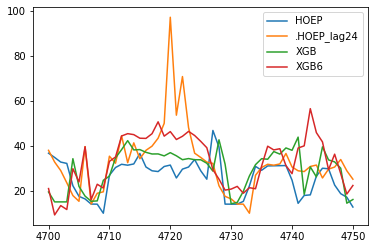

In [6]:
from sklearn.metrics import mean_squared_error
from numpy import corrcoef
import matplotlib.pyplot as plt 
df = data.loc[:8759]

RMSE_lag24 = np.sqrt(mean_squared_error(df.HOEP,df.HOEP_lag24))
print("RMSE HOEP_lag24:",round(RMSE_lag24,2),"Correlation:", corrcoef(df.HOEP,df.HOEP_lag24)[0,1])

RMSE_lag168 = np.sqrt(mean_squared_error(df.HOEP,df.HOEP_lag168))
print("RMSE HOEP_lag168:",round(RMSE_lag168,2),"Correlation:", corrcoef(df.HOEP,df.HOEP_lag168)[0,1])

RMSE_lag360 = np.sqrt(mean_squared_error(df.HOEP,df.HOEP_lag360))
print("RMSE HOEP_lag360:",round(RMSE_lag360,2), "Correlation:", corrcoef(df.HOEP,df.HOEP_lag360)[0,1])

RMSE_XGB = np.sqrt(mean_squared_error(df.HOEP,df.XGB))
print("RMSE XGB:",round(RMSE_XGB,2),"Correlation:", corrcoef(df.HOEP,df.XGB)[0,1])

RMSE_XGB6 = np.sqrt(mean_squared_error(df.HOEP,df.XGB6))
print("RMSE XGB6:",round(RMSE_XGB6,2),"Correlation:", corrcoef(df.HOEP,df.XGB6)[0,1])

RMSE_XGB12 = np.sqrt(mean_squared_error(df.HOEP,df.XGB12))
print("RMSE XGB12:",round(RMSE_XGB12,2),"Correlation:", corrcoef(df.HOEP,df.XGB12)[0,1])

RMSE_XGB24 = np.sqrt(mean_squared_error(df.HOEP,df.XGB24))
print("RMSE XGB24:",round(RMSE_XGB24,2),"Correlation:", corrcoef(df.HOEP,df.XGB24)[0,1])

test = df.loc[4700:4750]
plt.plot(test.HOEP, label = 'HOEP')
plt.plot(test.HOEP_lag24, label = '.HOEP_lag24')
plt.plot(test.XGB, label = 'XGB')
plt.plot(test.XGB6, label = 'XGB6')
plt.legend(loc='best')
plt.show()